In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs,make_moons,make_circles
from scipy.spatial.distance import mahalanobis
from scipy.spatial import distance_matrix
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris,fetch_openml
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

mnist = fetch_openml("mnist_784")
iris = load_iris(as_frame=True)

In [ ]:
def kmeans_artical(X, n_clusters, max_iterations=1000, tolerance=1e-4):
    n = len(X)  # Number of data points

    # Step 1: Randomly select k objects as initial cluster centers
    initial_indices = np.random.choice(n, n_clusters, replace=False)
    cluster_centers = X[initial_indices]

    # Initialize arrays to store cluster assignments and distances
    Cluster = np.zeros(n, dtype=int)
    Dist = np.full(n, np.inf)

    # Step 2 & 3: Assign data objects to the nearest cluster center
    for i in range(n):
        distances = np.linalg.norm(X[i] - cluster_centers, axis=1)
        nearest_cluster = np.argmin(distances)
        Cluster[i] = nearest_cluster
        Dist[i] = distances[nearest_cluster]

    for iteration in range(max_iterations):
        previous_centers = cluster_centers.copy()

        # Step 6-7: Adjust assignments if necessary
        for i in range(n):
            current_distance = np.linalg.norm(X[i] - cluster_centers[Cluster[i]])
            if current_distance > Dist[i]:
                distances = np.linalg.norm(X[i] - cluster_centers, axis=1)
                nearest_cluster = np.argmin(distances)
                Cluster[i] = nearest_cluster
                Dist[i] = distances[nearest_cluster]

        # Step 5: Recalculate cluster centers
        for j in range(n_clusters):
            cluster_points = X[Cluster == j]
            if len(cluster_points) > 0:
                cluster_centers[j] = np.mean(cluster_points, axis=0)

        # Check for convergence (if centers do not change significantly)
        center_shift = np.linalg.norm(cluster_centers - previous_centers)
        if center_shift <= tolerance:
            break

    return cluster_centers, Cluster


In [ ]:
def kmeans_global_mahalanobis(X, n_clusters, max_iterations=1000, tolerance=1e-4):
  eps = 1e-4
  n = len(X)  # Number of data points

  # Step 1: Randomly select k objects as initial cluster centers
  initial_indices = np.random.choice(n, n_clusters, replace=False)
  cluster_centers = KMeans(n_clusters=n_clusters, max_iter = 2).fit(X).cluster_centers_

  # Initialize arrays to store cluster assignments and distances
  Cluster = np.zeros(n, dtype=int)
  Dist = np.full(n, np.inf)

  # Step 2 & 3: Assign data objects to the nearest cluster center
  for _ in range(2):
    for i in range(n):
        distances = np.linalg.norm(X[i] - cluster_centers, axis=1)
        nearest_cluster = np.argmin(distances)
        Cluster[i] = nearest_cluster
        Dist[i] = distances[nearest_cluster]
  cov_inv = []
  for k in range(n_clusters):
      # Compute covariance matrix for Mahalanobis distance
      cov = np.cov(X[Cluster == k, :], rowvar=False)
      cov_inv.append(np.linalg.inv(cov+eps*np.eye(cov.shape[0])))

  for iteration in range(max_iterations):
      previous_centers = cluster_centers.copy()

      # Step 6-7: Adjust assignments if necessary
      for i in range(n):
          current_distance = mahalanobis(X[i] , cluster_centers[Cluster[i]],cov_inv[Cluster[i]])
          if current_distance > Dist[i]:
              distances = [mahalanobis(X[i], center, cov_inv[idx]) for idx,center in enumerate(cluster_centers)]
              nearest_cluster = np.argmin(distances)
              Cluster[i] = nearest_cluster
              Dist[i] = distances[nearest_cluster]

      # Step 5: Recalculate cluster centers
      for j in range(n_clusters):
          cluster_points = X[Cluster == j]
          if len(cluster_points) > 0:
              cluster_centers[j] = np.mean(cluster_points, axis=0)

      for k in range(n_clusters):
          # Compute covariance matrix for Mahalanobis distance
          cov = np.cov(X[Cluster == k, :], rowvar=False)
          cov_inv[k]= np.linalg.inv(cov+eps*np.eye(cov.shape[0]))

      # Check for convergence (if centers do not change significantly)
      center_shift = np.linalg.norm(cluster_centers - previous_centers)
      if center_shift <= tolerance:
          break

  return cluster_centers, Cluster

In [ ]:
def compute_cluster_covariance(cuurent_pos,X,labels, n_neighbors,cluster_dist):
    cluster = labels[cuurent_pos]
    cluster_points = X[labels == cluster]
    clusster_pos = np.where((cluster_points == X[cuurent_pos,:]).all(axis=1))
    nearst =np.squeeze(np.argsort(cluster_dist[cluster][clusster_pos,:]))
    print(nearst.shape)
    nearst= nearst[1:n_neighbors+1]
    print(nearst.shape)
    cov = np.cov(cluster_points[nearst,:], rowvar=False)
    return cov
def kmeans_local_mahalanobis(X, n_clusters, n_neighbors=10, max_iter=1000, tol=1e-4):
  kmeans = KMeans(n_clusters=n_clusters,max_iter=1).fit(X)
  cluster_centers = kmeans.cluster_centers_
  labels = kmeans.labels_
  cluster_dist = [distance_matrix(X[labels==c],X[labels==c]) for c in range(n_clusters)]
  cov_matrix = []
  n = len(X)  # Number of data points
  Cluster = np.zeros(n, dtype=int)
  Dist = np.full(n, np.inf)

  for i,x in enumerate(X):
    cov_matrix.append(np.linalg.inv(compute_cluster_covariance(i,X,
                                                              labels = labels,
                                                              n_neighbors=n_neighbors,
                                                              cluster_dist=cluster_dist)))
  print("first tep")
  for i,x in enumerate(X) :
    distances = []
    for center in cluster_centers:
      diff = x-center
      distances.append(np.sqrt(diff.T @ cov_matrix[i] @ diff))
    nearest_cluster = np.argmin(distances)
    Cluster[i] = nearest_cluster
    Dist[i] = distances[nearest_cluster]


  for _ in range(max_iter):
      previous_centers = cluster_centers.copy()

      # Step 1: Assign points to the nearest cluster based on local Mahalanobis distance
      labels = []
      for i,x in enumerate(X):
          diff = x-cluster_centers[Cluster[i]]
          current_distance = np.sqrt(diff.T @ cov_matrix[i] @ diff)
          if current_distance > Dist[i]:
             distances = []
             for center in cluster_centers:
                diff = x-center
                distances.append(np.sqrt(diff.T @ cov_matrix[i] @ diff))
             nearest_cluster = np.argmin(distances)
             Cluster[i] = nearest_cluster
             Dist[i] = distances[nearest_cluster]
          # Assign to the nearest cluster
          labels.append(Cluster[i])
      labels = np.array(labels)

      # Step 2: Update cluster centers
      new_centers = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])

      # Check for convergence
      if np.all(np.abs(cluster_centers - previous_centers) < tol):
          break
      cluster_dist = [distance_matrix(X[labels==c],X[labels==c]) for c in range(n_clusters)]

      for i,x in enumerate(X):
        cov_matrix[i](np.linalg.inv(compute_cluster_covariance(i,X,
                                                              labels = labels,
                                                              n_neighbors=n_neighbors,
                                                              cluster_dist=cluster_dist)))


  return centers, labels

In [ ]:
centroids, labels = kmeans_local_mahalanobis(iris_data,n_clusters,n_neighbors=10)

(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(51,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,)
(10,)
(77,

ValueError: m has more than 2 dimensions

In [ ]:
def calculate_accuracy(true_labels, predicted_labels):
    # Create a confusion matrix
    n_classes = len(np.unique(true_labels))
    n_clusters = len(np.unique(predicted_labels))
    confusion_matrix = np.zeros((n_classes, n_clusters), dtype=np.int32)

    for i in range(len(true_labels)):
        confusion_matrix[true_labels[i], predicted_labels[i]] += 1

    # Solve the assignment problem to maximize accuracy
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)

    # Compute accuracy
    accuracy = confusion_matrix[row_ind, col_ind].sum() / len(true_labels)
    return accuracy


In [ ]:
n_samples = 1000

<ipython-input-35-1d469d4e3174>:19: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  cluster_points = np.random.multivariate_normal(mean, cov, n_samples)


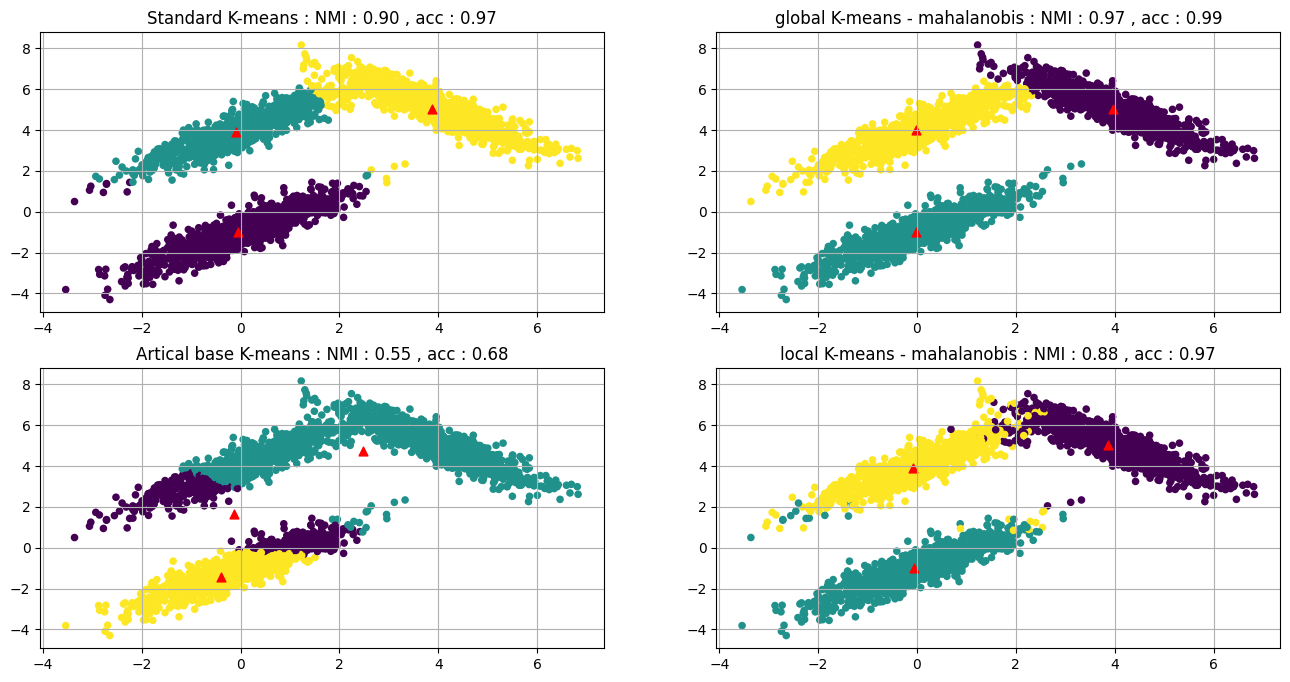

In [ ]:
n_clusters = 3

n_samples_per_cluster = n_samples*np.array([1, 1, 1])  # Number of samples per cluster
true_labels = np.int_(np.hstack([0*np.ones((n_samples,)),
                      1*np.ones((n_samples,)),
                      2*np.ones((n_samples,))]))
means = np.array([[0, -1], [4, 5], [0, 4]])       # Means of the clusters
covariances =np.array( [                         # Covariance matrices
    [[1, 1.1], [1.1, 1]],
    [[-1, 0.9], [0.9, -1]],
    [[1, 1.1], [1.1, 1] ]
])


 # Generate the blobs
X = []
y = []
for i, (mean, cov, n_samples) in enumerate(zip(means, covariances, n_samples_per_cluster)):
    cluster_points = np.random.multivariate_normal(mean, cov, n_samples)
    X.append(cluster_points)
    y.extend([i] * n_samples)

# Combine all clusters
X = np.vstack(X)
y = np.array(y)



kmeans = KMeans(n_clusters=n_clusters).fit(X)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
fig,axs = plt.subplots(2,2,figsize=(16, 8))

axs[0,0].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[0,0].scatter(centers[:,0],centers[:,1],marker = "^",s = 40,c= "red")
axs[0,0].grid(True)
axs[0,0].set_title("Standard K-means : NMI : {:.2f} , acc : {:.2f}".format(NMI(true_labels,labels),calculate_accuracy(true_labels,labels)))



centroids, labels = kmeans_artical(X,n_clusters,max_iterations=1000)
axs[1,0].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[1,0].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[1,0].grid(True)
axs[1,0].set_title("Artical base K-means : NMI : {:.2f} , acc : {:.2f}".format(NMI(true_labels,labels),calculate_accuracy(true_labels,labels)))


centroids, labels = kmeans_global_mahalanobis(X,n_clusters)
axs[0,1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[0,1].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[0,1].grid(True)
axs[0,1].set_title("global K-means - mahalanobis : NMI : {:.2f} , acc : {:.2f}".format(NMI(true_labels,labels),calculate_accuracy(true_labels,labels)))



centroids, labels = kmeans_local_mahalanobis(X,n_clusters,n_neighbors=10)
axs[1,1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[1,1].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[1,1].grid(True)
axs[1,1].set_title("local K-means - mahalanobis : NMI : {:.2f} , acc : {:.2f}".format(NMI(true_labels,labels),calculate_accuracy(true_labels,labels)))

plt.savefig("generated_simulation.png")
plt.show()


In [ ]:
num_of_iter = 100
regular_acc = np.zeros((num_of_iter,1))
regular_nmi = np.zeros((num_of_iter,1))
for idx in range(num_of_iter):
  kmeans = KMeans(n_clusters=n_clusters).fit(X)
  labels = kmeans.labels_
  regular_nmi[idx] = NMI(true_labels,labels)
  regular_acc[idx] = calculate_accuracy(true_labels,labels)

print("regoular Kmens acc mean = {:.2f} with var {:.2E}".format(np.mean(regular_acc),np.sqrt(np.var(regular_acc))))
print("regoular Kmens NMI mean = {:.2f} with var {:.2E}".format(np.mean(regular_nmi),np.sqrt(np.var(regular_nmi))))
print("---"*8)

artical_acc = np.zeros((num_of_iter,1))
artical_nmi = np.zeros((num_of_iter,1))
for idx in range(num_of_iter):
  _ , labels = kmeans_artical(X,n_clusters,max_iterations=1000)
  artical_nmi[idx] = NMI(true_labels,labels)
  artical_acc[idx] = calculate_accuracy(true_labels,labels)

print("artical Kmens acc mean = {:.2f} with var {:.2E}".format(np.mean(artical_acc),np.sqrt(np.var(artical_acc))))
print("artical Kmens NMI mean = {:.2f} with var {:.2E}".format(np.mean(artical_nmi),np.sqrt(np.var(artical_nmi))))
print("---"*8)


global_acc = np.zeros((num_of_iter,1))
global_nmi = np.zeros((num_of_iter,1))
for idx in range(num_of_iter):
  _ , labels = kmeans_global_mahalanobis(X,n_clusters)
  global_nmi[idx] = NMI(true_labels,labels)
  global_acc[idx] = calculate_accuracy(true_labels,labels)

print("global Kmens acc mean = {:.2f} with var {:.2E}".format(np.mean(global_acc),np.sqrt(np.var(global_acc))))
print("global Kmens NMI mean = {:.2f} with var {:.2E}".format(np.mean(global_nmi),np.sqrt(np.var(global_nmi))))
print("---"*8)


local_acc = np.zeros((num_of_iter,1))
local_nmi = np.zeros((num_of_iter,1))
for idx in range(num_of_iter):
  _ , labels = kmeans_local_mahalanobis(X,n_clusters,n_neighbors=10)
  local_nmi[idx] = NMI(true_labels,labels)
  local_acc[idx] = calculate_accuracy(true_labels,labels)

print("local Kmens acc mean = {:.2f} with var {:.2E}".format(np.mean(local_acc),np.sqrt(np.var(local_acc))))
print("local Kmens NMI mean = {:.2f} with var {:.2E}".format(np.mean(global_nmi),np.sqrt(np.var(local_nmi))))
print("---"*8)

regoular Kmens acc mean = 0.98 with var 1.63E-04
regoular Kmens NMI mean = 0.90 with var 7.20E-04
------------------------
artical Kmens acc mean = 0.90 with var 1.05E-01
artical Kmens NMI mean = 0.79 with var 1.22E-01
------------------------
global Kmens acc mean = 0.99 with var 4.99E-02
global Kmens NMI mean = 0.96 with var 6.57E-02
------------------------
local Kmens acc mean = 0.95 with var 6.99E-02
local Kmens NMI mean = 0.96 with var 6.76E-02
------------------------


# IRIS dataset

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


ValueError: m has more than 2 dimensions

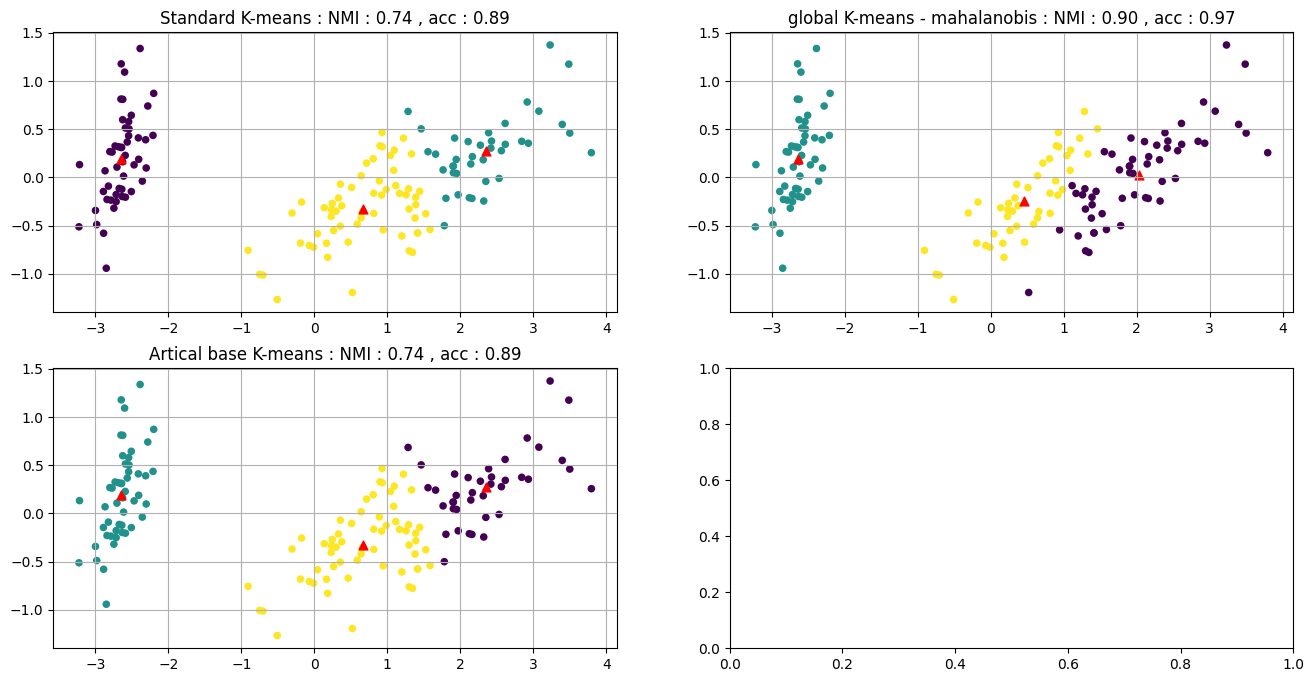

In [ ]:
iris_data = iris["data"].to_numpy()
n_clusters = len(iris["target"].unique())
pca = PCA(n_components=2).fit(iris.data)
X_reduced = pca.transform(iris.data)

kmeans = KMeans(n_clusters=n_clusters).fit(iris_data)
centers = pca.transform(kmeans.cluster_centers_)
labels = kmeans.labels_
fig,axs = plt.subplots(2,2,figsize=(16, 8))

axs[0,0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[0,0].scatter(centers[:,0],centers[:,1],marker = "^",s = 40,c= "red")
axs[0,0].grid(True)
axs[0,0].set_title("Standard K-means : NMI : {:.2f} , acc : {:.2f}".format(NMI(iris["target"],labels),calculate_accuracy(iris["target"],labels)))



centroids, labels = kmeans_artical(iris_data,n_clusters,max_iterations=1000)
centroids = pca.transform(centroids)
axs[1,0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[1,0].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[1,0].grid(True)
axs[1,0].set_title("Artical base K-means : NMI : {:.2f} , acc : {:.2f}".format(NMI(iris["target"],labels),calculate_accuracy(iris["target"],labels)))


centroids, labels = kmeans_global_mahalanobis(iris_data,n_clusters)
centroids = pca.transform(centroids)
axs[0,1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[0,1].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[0,1].grid(True)
axs[0,1].set_title("global K-means - mahalanobis : NMI : {:.2f} , acc : {:.2f}".format(NMI(iris["target"],labels),calculate_accuracy(iris["target"],labels)))


centroids, labels = kmeans_local_mahalanobis(iris_data,n_clusters,n_neighbors=10)
centroids = pca.transform(centroids)
axs[1,1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[1,1].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[1,1].grid(True)
axs[1,1].set_title("local K-means - mahalanobis : NMI : {:.2f} , acc : {:.2f}".format(NMI(iris["target"],labels),calculate_accuracy(iris["target"],labels)))
plt.savefig("IRIS.png")
plt.show()


# MNIST


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


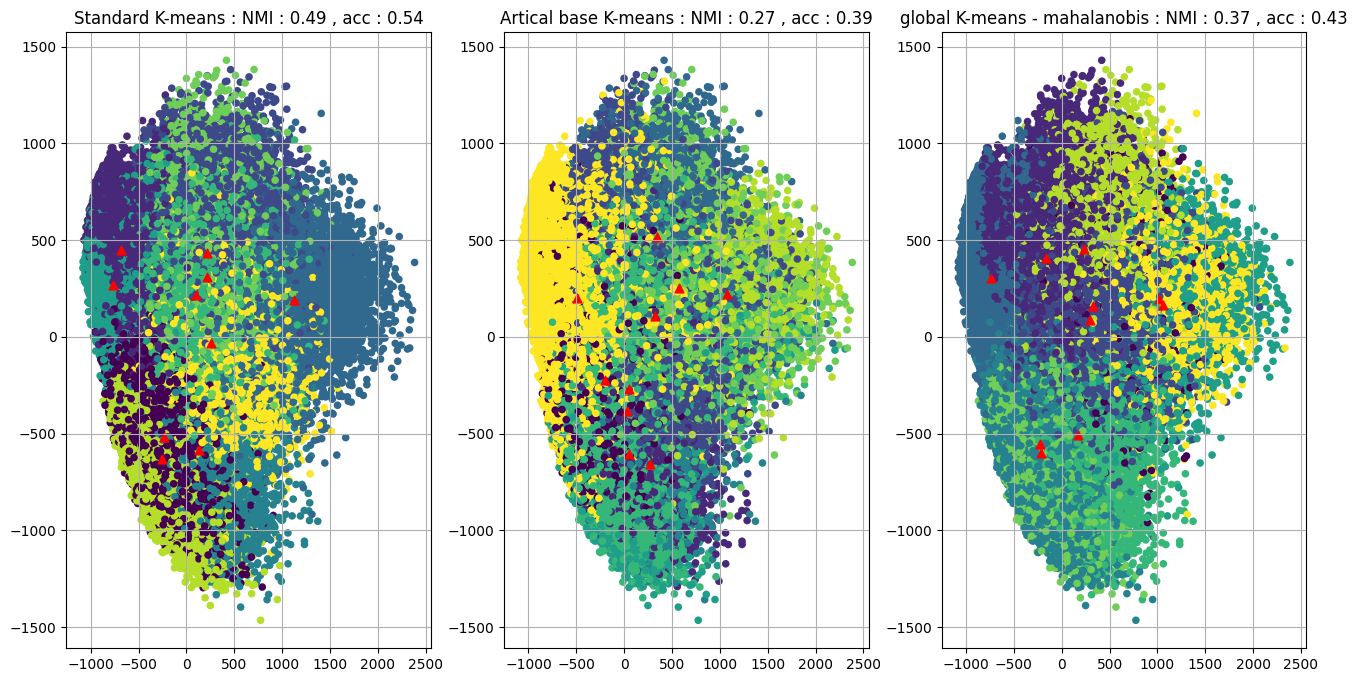

In [ ]:
mnist_data = mnist["data"].to_numpy()
n_clusters = len(mnist["target"].unique())
true_labels = mnist["target"].astype('int64').to_numpy()
pca = PCA(n_components=2).fit(mnist.data)
X_reduced = pca.transform(mnist.data)

kmeans = KMeans(n_clusters=n_clusters).fit(mnist_data)
centers = pca.transform(kmeans.cluster_centers_)
labels = kmeans.labels_
fig,axs = plt.subplots(1,3,figsize=(16, 8))

axs[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[0].scatter(centers[:,0],centers[:,1],marker = "^",s = 40,c= "red")
axs[0].grid(True)
axs[0].set_title("Standard K-means : NMI : {:.2f} , acc : {:.2f}".format(NMI(true_labels,labels),calculate_accuracy(true_labels,labels)))



centroids, labels = kmeans_artical(mnist_data,n_clusters,max_iterations=1000)
centroids = pca.transform(centroids)
axs[1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[1].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[1].grid(True)
axs[1].set_title("Artical base K-means : NMI : {:.2f} , acc : {:.2f}".format(NMI(true_labels,labels),calculate_accuracy(true_labels,labels)))


centroids, labels = kmeans_global_mahalanobis(mnist_data,n_clusters)
centroids = pca.transform(centroids)
axs[2].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[2].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[2].grid(True)
axs[2].set_title("global K-means - mahalanobis : NMI : {:.2f} , acc : {:.2f}".format(NMI(true_labels,labels),calculate_accuracy(true_labels,labels)))
plt.savefig("Mnist.png")
plt.show()


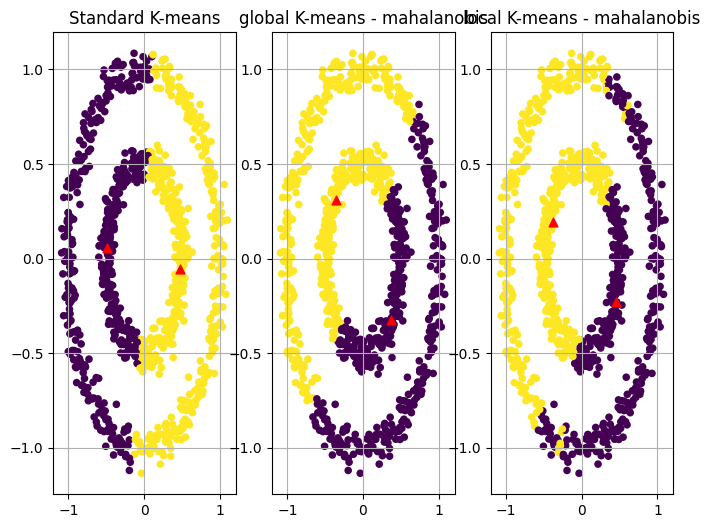

In [ ]:
X = make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)[0]
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
fig,axs = plt.subplots(1,3,figsize=(8, 6))

axs[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[0].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[0].grid(True)
axs[0].set_title("Standard K-means")



centroids, labels = kmeans_global_mahalanobis(X,n_clusters)
axs[1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[1].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[1].grid(True)
axs[1].set_title("global K-means - mahalanobis")


centroids, labels = kmeans_local_mahalanobis(X,n_clusters,n_neighbors=100)
axs[2].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[2].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[2].grid(True)
axs[2].set_title("local K-means - mahalanobis")
plt.show()

# New Section

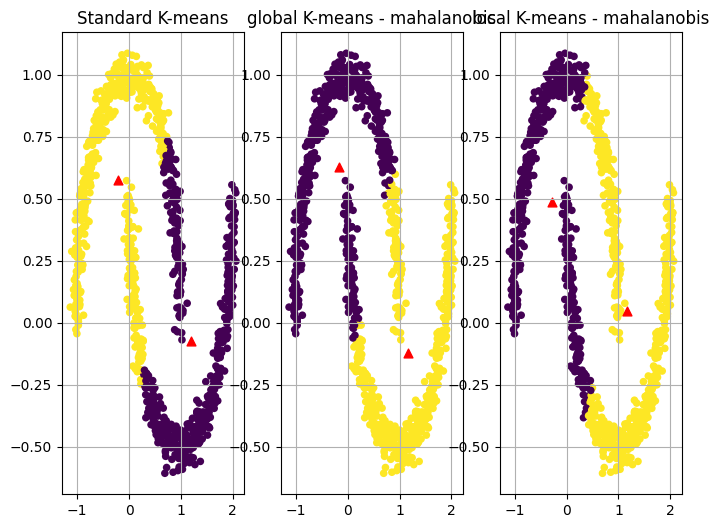

In [ ]:
X = make_moons(n_samples=n_samples,
                                      noise=.05)[0]
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
fig,axs = plt.subplots(1,3,figsize=(8, 6))

axs[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[0].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[0].grid(True)
axs[0].set_title("Standard K-means")



centroids, labels = kmeans_global_mahalanobis(X,n_clusters)
axs[1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[1].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[1].grid(True)
axs[1].set_title("global K-means - mahalanobis")


centroids, labels = kmeans_local_mahalanobis(X,n_clusters,n_neighbors=100)
axs[2].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, edgecolor='none')
axs[2].scatter(centroids[:,0],centroids[:,1],marker = "^",s = 40,c= "red")
axs[2].grid(True)
axs[2].set_title("local K-means - mahalanobis")
plt.show()